# Simple TDE Filter

Search for several broad line emission features characteristic of TDE spectra and select object with all or several of those features. Examples:
1. H$\alpha$ emission.
1. O III $\lambda5007$ line.
1. He II $\lambda4684$ line.
1. etc.

In [1]:
import os
import sys

from glob import glob      # This is used for "wildcard" searches of folders.

from abc import ABC

from astropy.table import Table
from astropy import units as u
from desispec.io import read_spectra, write_spectra
from desispec.spectra import stack as specstack
from desispec.coaddition import coadd_cameras

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.constants as constants
import scipy.signal

from scipy.ndimage import gaussian_filter1d
from scipy.stats import norm
from scipy.optimize import curve_fit

# import math
# import statistics

# import sys

## Access to Tile ToO from JuTy 2021

This is a dummy data set we'll use as a sandbox to test the TDE filter.

Locally cache the selected spectra so we don't have to have a time consuming loop and selectio over data.

In [2]:
redux = 'daily/tiles/cumulative'
basedir = os.environ['DESI_SPECTRO_REDUX']

tiles = ['80980', '80981']
tiledate = '20210708'

coadd_file = 'selected_coadds_80980_80981.fits'
use_cache = True

if os.path.exists(coadd_file) and use_cache:
    spectra = read_spectra(coadd_file)
else:    
    spectra = None
    # Loop over all tiles in our tile list.
    for tile in tiles:
        tilefolder = '{}/{}/{}/{}'.format(basedir, redux, tile, tiledate)
        coadds = sorted(glob('{}/coadd*.fits'.format(tilefolder)))

        # Loop over all petals in the spectroscopic reduction.
        for coadd in coadds:
            # Read the spectra and the best-fit redshifts from redrock and combine into one stack of spectra.
            spec = read_spectra(coadd)
            zbest_files = coadd.replace('coadd', 'zbest')
            zbest = Table.read(zbest_files, 'ZBEST')

            # Select spectra with good redshifts at low z to pick TDE candidates.
            select = (zbest['DELTACHI2']>25) & (zbest['ZWARN']==0) & (zbest['Z']<=0.15) & (zbest['SPECTYPE']=='GALAXY')

            # Match TARGETID between good redshifts in zbest and the spectra fibermap table.
            idx = np.in1d(spec.fibermap['TARGETID'], zbest['TARGETID'][select])

            # Coadd our selected (good redshift) spectra across the b, r, z cameras.
            cspec = coadd_cameras(spec[idx])
            cspec.scores = None
            cspec.extra_catalog = zbest[select]

            # Accumulate spectra from all petals into one object, "spectra."
            if spectra is None:
                spectra = cspec
            else:
                spectra = specstack([spectra, cspec])

    write_spectra(coadd_file, spectra)
    zbest = spectra.extra_catalog

INFO:spectra.py:282:read_spectra: iotime 0.759 sec to read selected_coadds_80980_80981.fits at 2021-08-24T12:37:49.648556


### Select Quality Redshifts

Select spectra with good redshifts according to redrock. We'll use this to move to the objects' restframes and look for TDE-like spectra lines.

In [3]:
spectra.fibermap

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MASKBITS,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,BRICKNAME,EBV,FLUX_W1,FLUX_W2,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,PLATE_RA,PLATE_DEC,PSF_TO_FIBER_SPECFLUX,TILEID,COADD_NUMEXP,COADD_EXPTIME,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_X,MEAN_FIBER_Y,MEAN_FIBER_RA,MEAN_FIBER_DEC,MEAN_FIBERASSIGN_X,MEAN_FIBERASSIGN_Y,FIRST_NIGHT,LAST_NIGHT,NUM_NIGHT,FIRST_EXPID,LAST_EXPID,NUM_EXPID,FIRST_TILEID,LAST_TILEID,NUM_TILEID,FIRST_FIBER,LAST_FIBER,NUM_FIBER,FIRST_MJD,LAST_MJD,NUM_MJD
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,int32,float64,int32,int16,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,int16,int64,bytes2,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,float64,float64,float64,int32,int16,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,int32,int32,int16,int32,int32,int16,int32,int32,int16,int32,int32,int16,float32,float32,int16
43978251332224297,0,522,522,478,0,218.813975,35.121953,0.0,0.0,2015.5,5400.0,4611686018427387904,1,TGT,950,0.9742937853685163,5,0,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0,0,,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,950,1,4611686018427387904,0,0,576460752303423488,218.813975,35.121953,0.7926560553510068,80980,2,2112.8784,-0.004,0.004,-0.004,0.004,37.89,-399.857,218.81395557359048,35.12196767708496,37.86777,-399.8724,20210708,20210708,1,97938,97939,2,80980,80980,1,478,478,1,59404.168,59404.184,2
43978251336418634,0,503,503,497,0,219.080169,35.122149,0.0,0.0,2015.5,5400.0,4611686018427387904,1,TGT,950,0.34329178283455775,5,0,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0,0,,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,950,1,4611686018427387904,0,0,576460752303423488,219.080169,35.122149,0.7924976169140224,80980,2,2112.8784,-0.001,0.001,-0.001,0.001,-17.279,-399.621,219.08016420293768,35.122152639496015,-17.301447,-399.6295,20210708,20210708,1,97938,97939,2,80980,80980,1,497,497,1,59404.168,59404.184,2
43978251340612978,0,483,483,345,0,219.292823,35.10903,0.0,0.0,2015.5,5400.0,4611686018427387904,1,TGT,950,0.7245738764353887,5,0,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0,0,,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,950,1,4611686018427387904,0,0,576460752303423488,219.292823,35.10903,0.7926175156620128,80980,2,2112.8784,-0.004,0.004,0.001,0.001,-61.447,-403.418,219.29280369081238,35.10902625495025,-61.476753,-403.43625,20210708,20210708,1,97938,97939,2,80980,80980,1,345,345,1,59404.168,59404.184,2
43978256277309425,0,476,476,362,0,218.737992,35.238934,0.0,0.0,2015.5,5400.0,4611686018427387904,1,TGT,950,0.3470135953025786,5,0,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0,0,,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,950,1,4611686018427387904,0,0,576460752303423488,218.737992,35.238934,0.7923371452480882,80980,2,2112.8784,-0.001,0.001,0.001,0.001,53.302,-368.135,218.7379871982229,35.238930326368056,53.28337,-368.13284,20210708,20210708,1,97938,97939,2,80980,80980,1,362,362,1,59404.168,59404.184,2
43978256277309427,0,510,510,397,0,218.745077,35.171691,0.0,0.0,2015.5,5400.0,4611686018427387904,1,TGT,950,0.7236805231892964,5,0,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0,0,,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,950,1,4611686018

In [4]:
spectra.extra_catalog

TARGETID,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,NUMEXP,NUMTILE
int64,float64,float64,float64,float64,int64,int64,bytes6,bytes20,int64,float64,int32,int32
43978251332224297,10275.067973563127,186.54133100184234 .. -2.139486242776249,0.028169338945036603,7.33099736174635e-05,0,7922,GALAXY,,10,57.97290327245719,0,1
43978251336418634,10230.57675677538,941.0080736739006 .. 15.082266471228863,0.04461884220088436,5.852139174486123e-06,0,7915,GALAXY,,10,947.8218576312065,0,1
43978251340612978,10124.402057901025,460.9684372706358 .. -21.52998659342644,0.05430422899565762,1.1063282222704019e-05,0,7909,GALAXY,,10,318.8440255969763,0,1
43978256277309425,11268.109929680824,3107.8662334522915 .. 49.173596003834135,0.05426746476189148,3.5887243507574826e-06,0,7918,GALAXY,,10,6545.918428844208,0,1
43978256277309427,10512.6166087389,2740.5318053403666 .. 117.80372789329931,0.07770015858870159,3.4346465435754205e-06,0,7924,GALAXY,,10,5390.012244582176,0,1
43978256277309431,12691.667140066624,5479.312467285019 .. 67.90531589745542,0.08530550495309075,7.3501910286467025e-06,0,7922,GALAXY,,10,8664.306151263416,0,1
43978256281503761,12625.321367502213,6281.767418081286 .. 7.142270691406357,0.04449776813100064,1.4916088727956e-06,0,7924,GALAXY,,10,27798.917276144028,0,1
43978256281503765,13706.790070198476,3748.771933120947 .. 304.3801057129196,0.054137654364171936,7.009412048980359e-06,0,7924,GALAXY,,10,4395.05174074322,0,1
43978256281503767,10185.300615906715,711.8935207803346 .. -57.17079478133657,0.08565691100877341,6.009421352586055e-06,0,7925,GALAXY,,10,882.6220356225967,0,1


In [5]:
spectra.num_spectra()

798

Text(0.5, 1.0, 'Picked coadded spectrum 622')

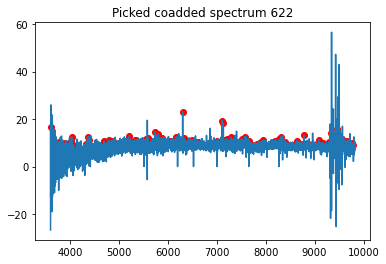

In [6]:
k = np.random.choice(spectra.num_spectra())
plt.plot(spectra.wave['brz'], spectra.flux['brz'][k])
peaks, info = scipy.signal.find_peaks(spectra.flux['brz'][k], prominence=0, width=5)
plt.scatter(spectra.wave['brz'][peaks], spectra.flux['brz'][k][peaks], color='r')
plt.title('Picked coadded spectrum {}'.format(k))
# info

array([  23,  220,  341,  368,  500,  528,  541,  574,  584,  654,  787,
        869,  904,  947,  989, 1215, 1348, 1371, 1404, 1412, 1457, 1478,
       1493, 1601, 1995, 2015, 2084, 2148, 2194, 2266, 2403, 2429, 2441,
       2449, 2465, 2486, 2511, 2539, 2567, 2664, 2755, 2763, 2796, 2802,
       2829, 2839, 2875, 3033, 3214, 3234, 3377, 3413, 3450, 3469, 3496,
       3627, 3646, 3719, 3776, 4032, 4212, 4259, 4389, 4417, 4438, 4499,
       4543, 4615, 4636, 4813, 4895, 4966, 5081, 5160, 5279, 5298, 5345,
       5383, 5434, 5709, 5733, 5827, 5840, 5891, 5944, 5958, 5981, 6109,
       6207, 6231, 6299, 6420, 6432, 6476, 6501, 6566, 6589, 6664, 6749,
       6853, 6962, 6998, 7036, 7048, 7122, 7181, 7206, 7322, 7339, 7442,
       7539, 7541, 7579, 7630, 7661, 7698, 7735])

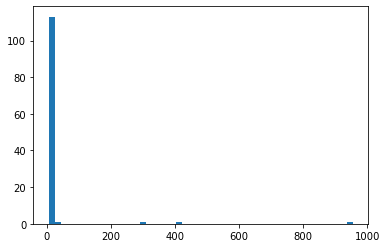

In [7]:
plt.hist(info['widths'], bins=50)
peaks

## TDE Filtering Code

In [8]:
# Search code implemented as a class.
def gauss2(x, b, a, x0, sigma):
    """Implementation of 1D Gaussian with arbitrary normalization.
    
    Parameters
    ----------
    x : ndarray
        List of independent values (ordinates) where we perform the fit.
    b : float
        Free parameter: constant offset.
    a : float
        Free parameter: normalization.
    x0 : float
        Location parameter of the Gaussian.
    sigma : float
        Scale parameter (width) of the Gaussian.
    
    Returns
    -------
    y : ndarray
        Gaussian function N(x|a,b,x0,sigma) evaluated for all x.
    """
    return b + (a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2)))


class TDEFilter_pEQW:
    ###########
    # Line pEQW measurements with linear continuum subtraction
    ###########

    import numpy as np
    import scipy.constants as constants
    from astropy import units as u
    import sys

    def __init__(self):
        pass
    def lines_for_analysis(self):
        """Serves as the internal line list in and information storage location.

        All lines included have the EQWs measured. 'Air' as these are line locations at STP"""

        spectral_lines_for_analysis_air = {
            'Halpha': [6562.79, 'indigo', [], [], [], [], [], [], [], [], [], [], [], [], [], []],
#             'Hbeta': [4861.35, 'indigo', [], [], [], [], [], [], [], [], [], [], [], [], [], []],
#             'Hgamma': [4340.472, 'indigo', [], [], [], [], [], [], [], [], [], [], [], [], [], []],
#             'Hdelta': [4101.734, 'indigo', [], [], [], [], [], [], [], [], [], [], [], [], [], []],

#             '[NII]6548': [6548, 'deeppink', [], [], [], [], [], [], [], [], [], [], [], [], [], []],
#             '[NII]6584': [6584, 'deeppink', [], [], [], [], [], [], [], [], [], [], [], [], [], []],

#             '[FeVII]3759': [3759, 'orangered', [], [], [], [], [], [], [], [], [], [], [], [], [], []],
#             '[FeVII]5160': [5160, 'orangered', [], [], [], [], [], [], [], [], [], [], [], [], [], []],
#             '[FeVII]5722': [5722, 'orangered', [], [], [], [], [], [], [], [], [], [], [], [], [], []],
#             '[FeVII]6088': [6088, 'orangered', [], [], [], [], [], [], [], [], [], [], [], [], [], []],
#             '[FeX]6376': [6376, 'orangered', [], [], [], [], [], [], [], [], [], [], [], [], [], []],
#             '[FeXI]7894': [7894, 'orangered', [], [], [], [], [], [], [], [], [], [], [], [], [], []],
#             '[FeXIV]5304': [5304, 'orangered', [], [], [], [], [], [], [], [], [], [], [], [], [], []],

#             '[OI]6300': [6300, 'mediumaquamarine', [], [], [], [], [], [], [], [], [], [], [], [], [], []],
#             '[OIII]4959': [4959, 'mediumaquamarine', [], [], [], [], [], [], [], [], [], [], [], [], [], []],
            '[OIII]5007': [5007, 'mediumaquamarine', [], [], [], [], [], [], [], [], [], [], [], [], [], []],

#             'HeI4478': [4478, 'royalblue', [], [], [], [], [], [], [], [], [], [], [], [], [], []],
            'HeII4686': [4686, 'royalblue', [], [], [], [], [], [], [], [], [], [], [], [], [], []],

#             'NaID': [5892.935, 'orange', [], [], [], [], [], [], [], [], [], [], [], [], [], []],

#             '[SII]6716': [6716, 'goldenrod', [], [], [], [], [], [], [], [], [], [], [], [], [], []],
#             '[SII]6731': [6731, 'goldenrod', [], [], [], [], [], [], [], [], [], [], [], [], [], []],

#             '[SII]6716,6731': [6723.5, 'goldenrod', [], [], [], [], [], [], [], [], [], [], [], [], [], []],

#             '[NeIII]3896': [3896, 'blueviolet', [], [], [], [], [], [], [], [], [], [], [], [], [], []],

        }

        return spectral_lines_for_analysis_air


    def region_cutter(self,shift, wave, flux, low_cut, high_cut, mode='Shift', error=None):
        """Cuts down a spectrum, flux, wavelength and determined shift, based on either a shift or wavelength region

        Defaults to shift for compatibility
        Expects wave and flux to have a unit but does NOT preserve these"""

        wave = wave.value
        flux = flux.value

        cut_shift = []
        cut_wave = []
        cut_flux = []
        cut_error = []

        if mode.lower() in {'shift', 'velocity'}:
            for xx, item in enumerate(shift):

                if low_cut <= shift[xx] <= high_cut:
                    cut_shift.append(shift[xx])
                    cut_wave.append(wave[xx])
                    cut_flux.append(flux[xx])
                    if error:
                        cut_error.append(error[xx])

                elif shift[xx] > high_cut:
                    break

        elif mode.lower() in {'wavelength', 'lambda'}:

            for xx, item in enumerate(wave):

                if low_cut <= wave[xx] <= high_cut:
                    cut_shift.append(shift[xx])
                    cut_wave.append(wave[xx])
                    cut_flux.append(flux[xx])
                    if error:
                        cut_error.append(error[xx])

                elif wave[xx] > high_cut:
                    break

        else:
            print('mode selection not recognised.\nPlease check and try again.')
            sys.exit()

        return cut_shift, cut_wave, cut_flux, cut_error


    def continua_maker(self,spec_region, flux, line_name, line_loc, object_name):
        """This version of the continua generator and corrector uses a wavelength region rather than a relative velocity"""

        if line_name.lower() in {'halpha', '[nii]6548', '[nii]6584'}:

            # These are the values Decker used for her paper with Or.
            # They will include parts of broad features so I am tweaking.
            """
            blue_start = 6492.8
            blue_end = 6532.8

            red_start = 6592.8
            red_end = 6632.8
            """
            blue_start = 6465
            blue_end = 6470

            red_start = 6620
            red_end = 6635

        elif line_name.lower() in {'[oiii]5007'}:

            blue_start = line_loc - 35
            blue_end = line_loc - 25

            red_start = line_loc + 30
            red_end = line_loc + 35

        else:
            blue_start = line_loc - 50
            blue_end = line_loc - 40

            red_start = line_loc + 50
            red_end = line_loc + 60

        continuum_regions = [blue_start, blue_end, red_start, red_end]

        blue_middle = (blue_start + blue_end) / 2
        red_middle = (red_start + red_end) / 2

        blue_flux = []
        red_flux = []

        for xx, wavelength_point in enumerate(spec_region):
            if blue_start < spec_region[xx] < blue_end:
                blue_flux.append(flux[xx])
            if red_start < spec_region[xx] < red_end:
                red_flux.append(flux[xx])

        try:
            m = (np.nanmean(red_flux) - np.nanmean(blue_flux)) / (red_middle - blue_middle)
            intercept = np.nanmean(blue_flux) - (m * blue_middle)

        except FloatingPointError:
            print("Something has gone wrong with the selection of part of the continuum - likely no valid points"
                  "\nSkipping object for now")
            print(f"{object_name}\t{line_name}")

            print(spec_region)

            return [], []

        continuum = []

        for xx, velocity in enumerate(spec_region):
            continuum.append((m * spec_region[xx]) + intercept)

        try:
            scaled_flux = np.array(flux) / np.array(continuum)
        except:
            print("Continuum Scaling Failure")
            print(flux)
            print(continuum)

            scaled_flux = np.array(flux)

        return continuum, scaled_flux, continuum_regions


    def eqw_measurement(self,scaled_flux, xaxis, line_loc, measurement_length=12):
        """Newer version of the EQW measurement - still uses the under the continuum summation
        Defaults to measuring 12 angstroms either side of the given line location though this can be changed as needed"""

        prepared_flux = []
        prepared_xaxis = []

        for ii, item in enumerate(xaxis):
            if (line_loc - measurement_length) < xaxis[ii] < (line_loc + measurement_length):
                prepared_flux.append(scaled_flux[ii])
                prepared_xaxis.append(xaxis[ii])

        continuum = np.array([1 for item in prepared_flux])  # Assumes the input flux has been scaled to 1

        sum = np.sum((prepared_flux - continuum) / continuum)
        delta = xaxis[1] - xaxis[0]
        eqw = delta * sum

        return eqw


    ##########################################

    def get_eqw_info(self,wave, flux):
        c = constants.value('speed of light in vacuum') / 1000  # Speed of light in kms^-1

        #################
        # Inputs
        #################

        ObjectName = 'Test'

        wave = wave * u.AA
        flux = flux * u.Unit('erg cm-2 s-1 AA-1')

        Spectral_Lines_For_Analysis_Air = self.lines_for_analysis()
        Spectral_Lines_For_Analysis_Air_Names = list(Spectral_Lines_For_Analysis_Air.keys())

        Lower_Wave_Cut = 75
        Upper_Wave_Cut = 75

        debug = False

        for ii, item in enumerate(Spectral_Lines_For_Analysis_Air):

            Line_Location = Spectral_Lines_For_Analysis_Air[item][0]

            # Velocity shift from line
            Shift = (((np.array(wave) * c) / Line_Location) - c)

            # Cut down the region for analysis
            # This may need to be tweaked currently 75 angstroms either side of the line
            # Will default to nans if spectrum does not extend to fully include these regions

            if wave[-1].value < Line_Location - Lower_Wave_Cut or wave[1].value > Line_Location + Upper_Wave_Cut:

                if debug:
                    print(f"Analysis region \n{Spectral_Lines_For_Analysis_Air_Names[ii]} "
                          f"is not fully covered in the rest frame.")

                Spectral_Lines_For_Analysis_Air[item][2] = np.nan
                Spectral_Lines_For_Analysis_Air[item][3] = np.nan
                Spectral_Lines_For_Analysis_Air[item][4] = np.nan
                Spectral_Lines_For_Analysis_Air[item][5] = np.nan
                Spectral_Lines_For_Analysis_Air[item][6] = np.nan
                Spectral_Lines_For_Analysis_Air[item][7] = np.nan
                Spectral_Lines_For_Analysis_Air[item][8] = -999
                Spectral_Lines_For_Analysis_Air[item][9] = np.nan
                Spectral_Lines_For_Analysis_Air[item][10] = np.nan
                Spectral_Lines_For_Analysis_Air[item][11] = np.nan

            else:
                Shift_Region, Wave_Region, flux_Region, Error_Region = self.region_cutter(
                    shift=Shift, wave=wave,
                    flux=flux,
                    low_cut=Line_Location - Lower_Wave_Cut,
                    high_cut=Line_Location + Upper_Wave_Cut,
                    mode='Wavelength'
                )

                # Generate and remove a continuum fit from the flux data - currently linear other functions seem worse
                # The scaled flux output - Continuum[1] - is scaled to a continuum value of 1
                # The returned continuum values - Continuum[0] - is relative to the original unscaled spectrum
                Continuum = self.continua_maker(
                    spec_region=Wave_Region,
                    flux=flux_Region,
                    # shift=Shift_Region,
                    line_name=list(Spectral_Lines_For_Analysis_Air)[ii],
                    line_loc=Line_Location,
                    object_name=ObjectName
                )

                # Measure the resulting pEQW of the feature

                pEQW_LinCon_Spec = self.eqw_measurement(
                    scaled_flux=Continuum[1],
                    xaxis=Wave_Region,
                    line_loc=Line_Location
                )

                # Store the results in the main dictionary
                Spectral_Lines_For_Analysis_Air[item][2] = Shift
                Spectral_Lines_For_Analysis_Air[item][3] = Shift_Region
                Spectral_Lines_For_Analysis_Air[item][4] = Wave_Region
                Spectral_Lines_For_Analysis_Air[item][5] = flux_Region
                Spectral_Lines_For_Analysis_Air[item][6] = Continuum[0]
                Spectral_Lines_For_Analysis_Air[item][7] = Continuum[1]

                if np.isnan(pEQW_LinCon_Spec):
                    Spectral_Lines_For_Analysis_Air[item][8] = -9999
                else:
                    Spectral_Lines_For_Analysis_Air[item][8] = pEQW_LinCon_Spec
        return Spectral_Lines_For_Analysis_Air
    
    def is_tde(self, wave, flux):
        
        # Call the peak finder for the spectral features we want.
        line_info = self.get_eqw_info(wave,flux)
        try:
            heii_pars = line_info['HeII4686'][8]
            oiii_pars = line_info['[OIII]5007'][8]
            halpha_pars = line_info['Halpha'][8]
        except:
            return False
        
#         print(heii_pars)
#         print(oiii_pars)
#         print(halpha_pars)
            
        # Try to identify the TDE-like features.
        # Must have Ha and HeII lines.
        if heii_pars is None or halpha_pars is None:
            return False
        he_ha_ratio = heii_pars / halpha_pars
        
        # OIII line not required; set to zero by default.
        o_ha_ratio = 0.
        if oiii_pars is not None:
            o_ha_ratio = oiii_pars / halpha_pars

        # Condition: high HeII/Ha and little to no OIII/Ha.
        return he_ha_ratio > 0.9 and o_ha_ratio < 0.1
class TDEFilter_gauss:
    
    def __init__(self):
        self.heii_line_range = [4670., 4700.]
        self.oiii_line_range = [4992., 5022.]
        self.halpha_line_range = [6540., 6570.]
        
    def get_peak_in_range(self, wave, flux, wrange):
        # Pick out the desired wavelength subrange of the spectrum.
        wmin, wmax = wrange
#        i, j = 0, len(wave)   # TEMPORARY: DELETE AFTER TESTING!
        i = np.abs(wmin - wave).argmin()
        j = np.abs(wmax - wave).argmin()
        prom = 0
        width = 10*np.diff(wave)
        # Apply the scipy peak finder to the subarray.
        peaks, info = scipy.signal.find_peaks(flux[i:j], prominence=prom, width=width)

        if len(peaks) > 0:
            # Pick out the maximum flux in this range (eliminates noise/local minima).
            k = flux[peaks].argmax()
            peakidx = peaks[k]
            peakflux = flux[peakidx]
            peakwave = wave[peakidx]
            peakwidth = info['widths'][k]
            return peakidx, peakwave, peakwidth, peakflux

        return None
    
    def snip_data_near_peak(self, wave, flux, good_peak, good_width):
        # Extract a range of values in pixel space (2.2*peak finder width).
        peak_edge = int(np.floor(2.2*(good_width)))
        i = np.maximum(0, good_peak - peak_edge)
        j = np.minimum(len(wave), good_peak + peak_edge)
        
        return wave[i:j], flux[i:j]
    
    def get_line_features(self, wave, flux, wrange):
        # Call the peak finder for the spectrum.
        peakinfo = self.get_peak_in_range(wave, flux, wrange)
        if peakinfo is not None:
            # Extract a range around the peak.
            peakidx, peakwave, peakwidth, peakflux = peakinfo
            subwave, subflux = self.snip_data_near_peak(wave, flux, peakidx, peakwidth)
            # Fit the feature to a 1D Gaussian.
            pars, cov = curve_fit(gauss2, subwave, subflux, p0=[1., peakflux, peakwave, peakwidth])
            return pars
        return None
            
    def is_tde(self, wave, flux):
        
        # Call the peak finder for the spectral features we want.
        try:
            heii_pars = self.get_line_features(wave, flux, self.heii_line_range)
            oiii_pars = self.get_line_features(wave, flux, self.oiii_line_range)
            halpha_pars = self.get_line_features(wave, flux, self.halpha_line_range)
        except:
            return False
        
#         print(heii_pars)
#         print(oiii_pars)
#         print(halpha_pars)
            
        # Try to identify the TDE-like features.
        # Must have Ha and HeII lines.
        if heii_pars is None or halpha_pars is None:
            return False
        he_ha_ratio = heii_pars[1] / halpha_pars[1]
        
        # OIII line not required; set to zero by default.
        o_ha_ratio = 0.
        if oiii_pars is not None:
            o_ha_ratio = oiii_pars[1] / halpha_pars[1]

        # Condition: high HeII/Ha and little to no OIII/Ha.
        return he_ha_ratio > 0.9 and o_ha_ratio < 0.1

# Run the TDE filter using Gaussian fits
## Runs over both imported tiles after selection

In [9]:
for i in range(spectra.num_spectra()):
    is_tde = TDEFilter_gauss().is_tde(spectra.wave['brz'], gaussian_filter1d(spectra.flux['brz'][i], 5))
#     print('{} {}'.format(spectra.fibermap['TARGETID'][i], is_tde))
    if is_tde:
        targid = spectra.fibermap['TARGETID'][i]
        fig, ax = plt.subplots(1,1, figsize=(10,4), tight_layout=True)
        ax.plot(spectra.wave['brz'], gaussian_filter1d(spectra.flux['brz'][i], 5))
        ax.set(title='{:d} (spec {:d})'.format(targid, i))

# Run the TDE filter using calculated pEQW
## Runs over both imported tiles after selection

In [10]:
for i in range(spectra.num_spectra()):
    z = spectra.extra_catalog[i]['Z']
    is_tde = TDEFilter_pEQW().is_tde(spectra.wave['brz']/(1+z), gaussian_filter1d(spectra.flux['brz'][i], 5))
#     print('{} {}'.format(spectra.fibermap['TARGETID'][i], is_tde))
    if is_tde:
        fig, ax = plt.subplots(1,1, figsize=(10,4), tight_layout=True)
        ax.plot(spectra.wave['brz'], gaussian_filter1d(spectra.flux['brz'][i], 5))
        ax.set(title='{:d} (spec {:d})'.format(targid, i))

<ipython-input-8-4596293f6c7c>:179: RuntimeWarning: Mean of empty slice
  m = (np.nanmean(red_flux) - np.nanmean(blue_flux)) / (red_middle - blue_middle)
<ipython-input-8-4596293f6c7c>:180: RuntimeWarning: Mean of empty slice
  intercept = np.nanmean(blue_flux) - (m * blue_middle)
<ipython-input-8-4596293f6c7c>:197: RuntimeWarning: invalid value encountered in true_divide
  scaled_flux = np.array(flux) / np.array(continuum)


## Sanity to check to make sure the region the code is looking at actually falls on our peaks of interest

<ipython-input-8-4596293f6c7c>:179: RuntimeWarning: Mean of empty slice
  m = (np.nanmean(red_flux) - np.nanmean(blue_flux)) / (red_middle - blue_middle)
<ipython-input-8-4596293f6c7c>:180: RuntimeWarning: Mean of empty slice
  intercept = np.nanmean(blue_flux) - (m * blue_middle)
<ipython-input-8-4596293f6c7c>:179: RuntimeWarning: Mean of empty slice
  m = (np.nanmean(red_flux) - np.nanmean(blue_flux)) / (red_middle - blue_middle)
<ipython-input-8-4596293f6c7c>:180: RuntimeWarning: Mean of empty slice
  intercept = np.nanmean(blue_flux) - (m * blue_middle)
<ipython-input-8-4596293f6c7c>:179: RuntimeWarning: Mean of empty slice
  m = (np.nanmean(red_flux) - np.nanmean(blue_flux)) / (red_middle - blue_middle)
<ipython-input-8-4596293f6c7c>:180: RuntimeWarning: Mean of empty slice
  intercept = np.nanmean(blue_flux) - (m * blue_middle)
<ipython-input-8-4596293f6c7c>:179: RuntimeWarning: Mean of empty slice
  m = (np.nanmean(red_flux) - np.nanmean(blue_flux)) / (red_middle - blue_middle)


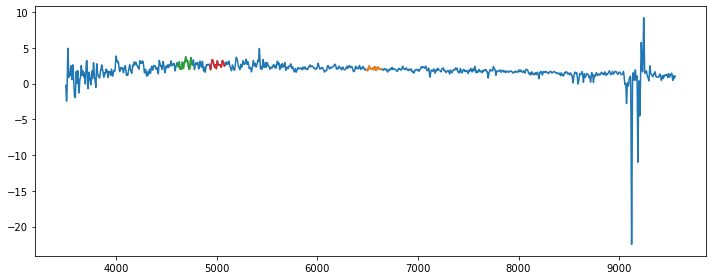

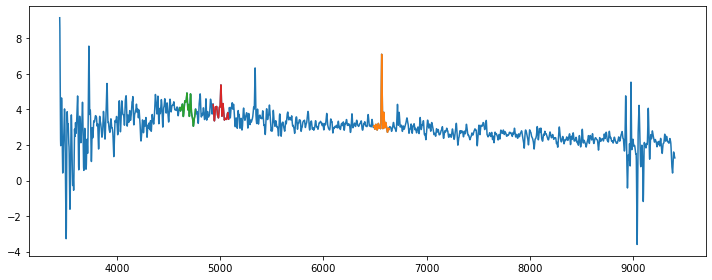

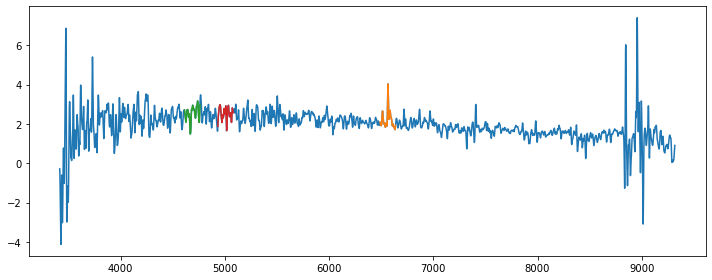

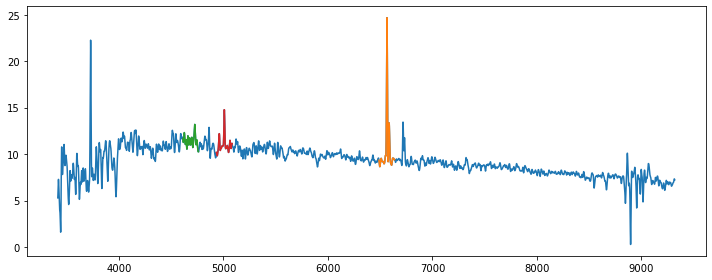

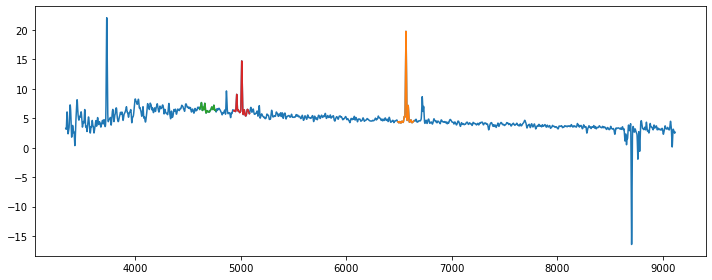

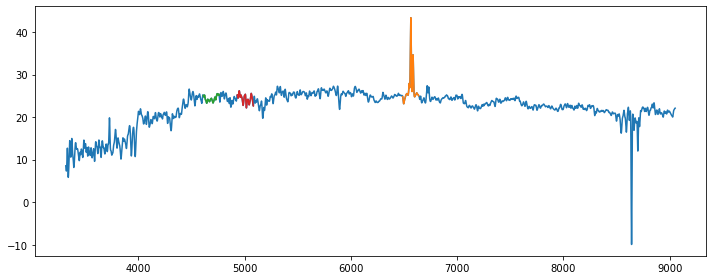

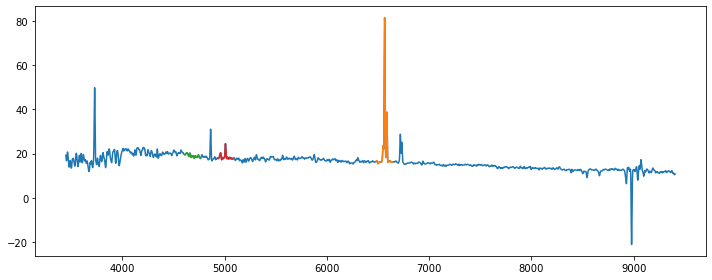

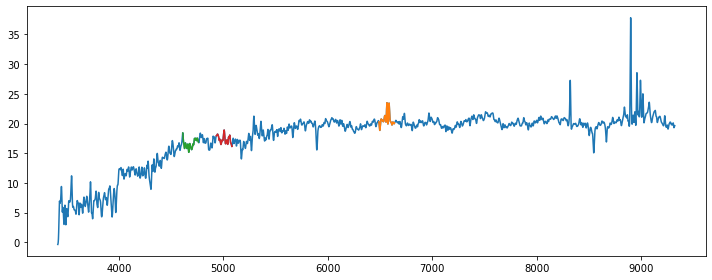

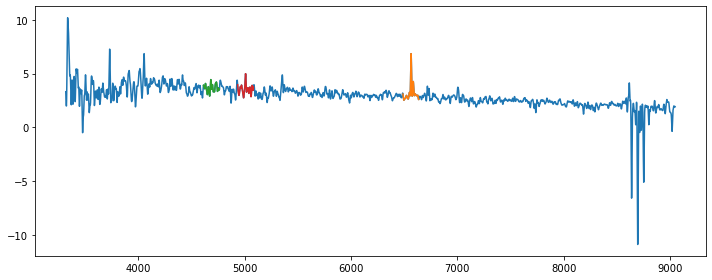

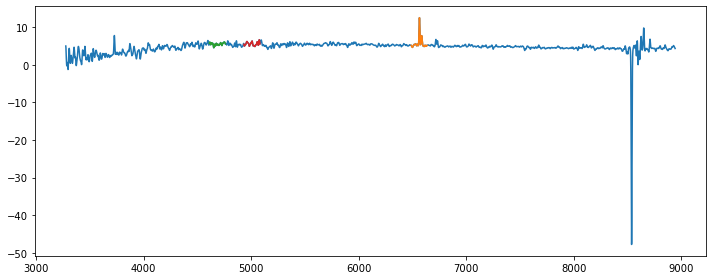

In [12]:
for i in range(10):
    z = spectra.extra_catalog[i]['Z']
    fig, ax = plt.subplots(1,1, figsize=(10,4), tight_layout=True)
    ax.plot(spectra.wave['brz']/(1+z), gaussian_filter1d(spectra.flux['brz'][i], 5))
    lines = TDEFilter_pEQW().get_eqw_info(spectra.wave['brz']/(1+z), gaussian_filter1d(spectra.flux['brz'][i], 5))
    ax.plot(lines['Halpha'][4],lines['Halpha'][5])
    ax.plot(lines['HeII4686'][4],lines['HeII4686'][5])
    ax.plot(lines['[OIII]5007'][4],lines['[OIII]5007'][5])

In [ ]:
# Defining the most important parts of the peak finder algorithm.

def gauss2(x, b, a, x0, sigma):
    """Implementation of 1D Gaussian with arbitrary normalization.
    
    Parameters
    ----------
    x : ndarray
        List of independent values (ordinates) where we perform the fit.
    b : float
        Free parameter: constant offset.
    a : float
        Free parameter: normalization.
    x0 : float
        Location parameter of the Gaussian.
    sigma : float
        Scale parameter (width) of the Gaussian.
    
    Returns
    -------
    y : ndarray
        Gaussian function N(x|a,b,x0,sigma) evaluated for all x.
    """
    return b + (a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2)))
    
def sub_list_into_max(thelist, flux):
    """Basically, return arg max(flux[j]), where j indexes local maxima.
    
    Parameters
    ----------
    thelist : ndarray of int
        Index of values used to search.
    flux : ndarray of float
        List of local maxima in the flux.
    
    Returns
    -------
    argmax : int
        Index of the global maximum out of the list of local maxima.
    """
    maximum = 0
    max_index = 0
    for k in range(len(thelist)):
        if flux[thelist[k]] > maximum:
            maximum = flux[thelist[k]]
            max_index = k
    return max_index

def has_peak_in_range(wave,flux,prom,wid,minwave,maxwave):
    """Find a peak (local maximum) in flux vs. wavelength within some wavelength range.
    
    Parameters
    ----------
    wave : ndarray
        Array of input wavelengths in a spectrum.
    
    flux : ndarray
        Flux values in a spectrum.
    
    prom : float
        Topological prominence of the local maximum to find (threshold/cut value).
    
    wid : int or float
        Minimum width (in pixels) identifying a peak.
    
    minwave : float
        Minimum wavelength in search range.
    
    maxwave : float
        Maximum wavelength in search range.
    
    Returns
    -------
    best_peak : int
        Index of the best-fit peak.
    best_width : float
        Width of the best-fit peak.
    """
    # rest wavelength in angstroms, arbitrary flux
    good_peaks = []
    good_widths = []
    peaks, widths = scipy.signal.find_peaks(flux, prominence = prom, width = wid)
    widths = widths["widths"]
    best_peak = None
    best_width = 0
    if len(peaks) != 0:
        for k in range(len(peaks)):
            if (minwave <= wave[peaks[k]]):
                if (wave[peaks[k]] <= maxwave):
                    good_peaks.append(peaks[k])
                    good_widths.append(widths[k])
        if good_peaks == []:
            return best_peak, best_width
        max_index = sub_list_into_max(good_peaks,flux)
        best_peak = good_peaks[max_index]
        best_width = good_widths[max_index]
        return best_peak, best_width
    else:
        return best_peak, best_width
    
def snip_data_near_peak(wave,flux,good_peak,good_width):
    """Given a peak, select a data range for performing a Gaussian fit.
    
    Parameters
    ----------
    wave : ndarray
        Array of input wavelengths in a spectrum.
    
    flux : ndarray
        Flux values in a spectrum.
    
    good_peak : int
        Index (in wave/flux arrays) of peak being fit.
    
    good_width : float
        Width of peak being fit.
    
    Returns
    -------
    snipped_wave : ndarray
        Selected wavelength range around the peak.
    snipped_flux : ndarray
        Selected flux values around the peak.
    """
    peak_edge = math.floor(2.2*(good_width))
    try:
        snipped_wave = wave[good_peak-peak_edge:good_peak+peak_edge]
        snipped_flux = flux[good_peak-peak_edge:good_peak+peak_edge]
    except:
        if (good_peak - peak_edge) < 0:
            snipped_wave = wave[0:good_peak+peak_edge]
            snipped_flux = flux[0:good_peak+peak_edge]
        else:
            snipped_wave = wave[good_peak - peak_edge:len(wave)-1]
            snipped_flux = flux[good_peak - peak_edge:len(wave)-1]
    return snipped_wave,snipped_flux

def fit_gaussian_to_peak(wave,flux,good_peak,good_width):
    """Fit 1D Gaussian to a subselection of a spectrum using a Levenberg-Marquardt minimization.
    
    Parameters
    ----------
    wave : ndarray
        Array of input wavelengths in a spectrum.
    
    flux : ndarray
        Flux values in a spectrum.
    
    good_peak : int
        Index (in wave/flux arrays) of peak being fit.
    
    good_width : float
        Width of peak being fit.
    
    Returns
    -------
    params : list
        List of best-fit 1D Gaussian parameters (xrange, offset, norm, loc, width).
    """
    
    snipped_wave, snipped_flux = snip_data_near_peak(wave,flux,good_peak,good_width)
    params, _ = curve_fit(gauss2, snipped_wave, snipped_flux,p0=[prom,max(snipped_flux),wave[good_peak],wid])
    return params #xrange, offset, height, average, width

def is_TDE(he_params,o_params,h_params):
    """
    Parameters
    ----------
    he_params : list
        wrange, offset, norm, loc, width of He II line.
    o_params : list
        wrange, offset, norm, loc, width of O III line.
    h_params : list
        wrange, offset, norm, loc, width of Halpha line.
    
    Returns
    -------
    is_tde : bool
        If true, sufficient features present for a TDE classification.
    """
    if he_params == []:
        return False
    elif h_params == []:
        return False
    line_ratio = he_params[1]/h_params[1]
    o_ratio = o_params[1]/h_params[1]
    if line_ratio == []:
        return False
    if line_ratio >= 0.9:
        print(line_ratio)
        if o_ratio <= 0.1:
            return True
        elif o_params == []:
            return True
        return False
    return False

# Test to see if the code works for DESI data

In [ ]:
total = sum(select)
prom  = 0
wid = 0

for j in range(sum(select)):
    targetid = spectra.fibermap[select][j]['TARGETID']
    z = spectra.extra_catalog[select][j]['Z']
    smoothed = []
    restwave = []
    good_he_peaks = []
    good_o_peaks = []
    good_h_peaks = []
    good_he_widths = []
    good_o_widths = []
    good_h_widths = []
    for band in spectra.bands:
        smoothed.append(gaussian_filter1d(spectra.flux[band][select][j], 5))
        restwave.append(spectra.wave[band]/(1+z))
    for k in range(len(smoothed)):
        he_peaks,he_widths = has_peak_in_range(restwave[k],smoothed[k],prom,wid,4670,4700)
        o_peaks,o_widths = has_peak_in_range(restwave[k],smoothed[k],prom,wid,4992,5022)
        h_peaks,h_widths = has_peak_in_range(restwave[k],smoothed[k],prom,wid,6540,6570)
        good_he_peaks.extend(he_peaks)
        good_o_peaks.extend(o_peaks)
        good_h_peaks.extend(h_peaks)
        good_he_widths.extend(he_widths)
        good_o_widths.extend(o_widths)
        good_h_widths.extend(h_widths)
    if
        for k in range(len(smoothed)):
            he_params = fit_gaussian_to_peak(restwave,smoothed[k],good_he_peaks,good_he_widths)
            o_params = fit_gaussian_to_peak(restwave,smoothed[k],good_o_peaks,good_o_widths)
            h_params = fit_gaussian_to_peak(restwave,smoothed[k],good_h_peaks,good_h_widths)
        if he_params == []:
            pass
        elif h_params == []:
            pass
        else:
            result = is_TDE(he_params,o_params,h_params)

            if result is True:
                print(targetid)

# Test on TDE.space data

### iPTF16axa from ApJ Screenshot (!)

In [ ]:
dct0613 = Table.read('DCT_0613.csv', names=['wave', 'flux'])
wave = dct0613['wave']
flux = dct0613['flux']

fig, axes = plt.subplots(1,3, figsize=(14,4), tight_layout=True)

ax = axes[0]
ax.plot(wave, flux)
ax.set(xlabel='$\lambda$ [$\AA$]',
       ylabel='flux [a.u.]');

ax = axes[1]
ax.plot(wave, wave*flux)
ax.set(xlabel='$\lambda$ [$\AA$]',
       ylabel='$\lambda F_\lambda$ [a.u.]');

ax = axes[2]
ax.hist(wave, bins=6, weights=wave*flux, log=True)
ax.set(xlabel='$\lambda$ [$\AA$]',
       ylabel='$\lambda F_\lambda$ [a.u.]');

In [ ]:
wave = []
flux = []
new_flux = []
restwave = []
file = open('samplePaperTDE.txt', 'r')

prom  = 0
wid = 0
z = 0.043671

for line in file.readlines():
    currentline = line.rstrip().split("")
    wave.append(float(currentline[0]))
    flux.append(float(currentline[1]))
for k in range(len(flux)):
    new_flux.append(flux[k]*math.pow(10.0,16.0))
    restwave.append(wave[k]/(1+z))
smoothed = [gaussian_filter1d(new_flux, 5)]
good_he_peaks = []
good_o_peaks = []
good_h_peaks = []
good_he_widths = []
good_o_widths = []
good_h_widths = []
he_params = []
o_params = []
h_params = []

for k in range(len(smoothed)):
    he_peaks,he_widths = has_peak_in_range(restwave,smoothed[k],prom,wid,4670,4700)
    o_peaks,o_widths = has_peak_in_range(restwave,smoothed[k],prom,wid,4992,5022)
    h_peaks,h_widths = has_peak_in_range(restwave,smoothed[k],prom,wid,6540,6570)
    good_he_peaks.extend(he_peaks)
    good_o_peaks.extend(o_peaks)
    good_h_peaks.extend(h_peaks)
    good_he_widths.extend(he_widths)
    good_o_widths.extend(o_widths)
    good_h_widths.extend(h_widths)

for k in range(len(smoothed)):
    for j in range(len(good_he_peaks)):
        he_params.append(fit_gaussian_to_peak(restwave,smoothed[k],good_he_peaks[j],good_he_widths[j]))
    for j in range(len(good_o_peaks)):
        o_params.append(fit_gaussian_to_peak(restwave,smoothed[k],good_o_peaks[j],good_o_widths[j]))
    for j in range(len(good_h_peaks)):
        h_params.append(fit_gaussian_to_peak(restwave,smoothed[k],good_h_peaks[j],good_h_widths[j]))

if he_params == []:
    pass
elif h_params == []:
    pass
else:
    result = is_TDE(he_params,o_params,h_params)

    if result is True:
        print('It is a TDE!')
plt.plot(restwave,new_flux)

In [ ]:
lambda_F = []

for k in range(len(restwave)):
    lambda_F.append(new_flux[k]*restwave[k])


In [ ]:

plt.plot(restwave,lambda_F)

In [ ]:
nbins = 30

n, _ = np.histogram(restwave, bins=nbins)
sy, _ = np.histogram(restwave, bins=nbins, weights=lambda_F)
sy2, _ = np.histogram(restwave, bins=nbins, weights=np.multiply(lambda_F,lambda_F))
average = sy/n
std = np.sqrt(sy2/n - average*average)

plt.plot(restwave, lambda_F, 'bo')
plt.errorbar((_[1:] + _[:-1])/2, average, yerr=std, fmt='r-')
plt.show()